In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import seaborn as sns

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import seaborn as sns

# Define paths
data_root = "archive(14)"
train_dir = os.path.join(data_root, "Training")
test_dir = os.path.join(data_root, "Testing")

# Define classes
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
num_classes = len(classes)

# Create a custom dataset class
class TumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
                
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg')):
                    self.samples.append((os.path.join(class_dir, img_name), self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [3]:
# Data transformations
# Using normalization values from ImageNet as these are standard for pretrained models
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard input size for many CNNs
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = TumorDataset(train_dir, transform=train_transforms)
test_dataset = TumorDataset(test_dir, transform=test_transforms)

# Check dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 5712
Testing dataset size: 1311


In [4]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the model (using a pre-trained ResNet-50)
def create_model():
    model = models.resnet50(pretrained=True)
    
    # Freeze early layers (optional - can improve training for small datasets)
    for param in list(model.parameters())[:-20]:
        param.requires_grad = False
    
    # Replace the final fully connected layer
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # Add dropout to prevent overfitting
        nn.Linear(in_features, num_classes)
    )
    
    return model

# Create the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = create_model().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


Using device: cuda


/home/dalton/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dalton/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/dalton/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_train_loss = running_loss / len(train_dataset)
        epoch_train_acc = running_corrects.double() / len(train_dataset)
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
        
        epoch_val_loss = running_loss / len(test_dataset)
        epoch_val_acc = running_corrects.double() / len(test_dataset)
        
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())
        
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')
        
        # Adjust learning rate
        scheduler.step(epoch_val_loss)
        
        # Save best model
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_tumor_classifier.pth')
            print(f'New best model saved with accuracy: {best_acc:.4f}')
        
        print()
    
    return model, history

In [6]:
# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate and print accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return accuracy, all_preds, all_labels

In [7]:
# Plot training history
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

In [8]:
# Function for detailed metrics calculation
def calculate_detailed_metrics(true_labels, predictions, class_names):
    """
    Calculate and display detailed performance metrics for each class.
    Also generates a formatted markdown table for README documentation.
    
    Args:
        true_labels (list): Ground truth labels
        predictions (list): Model predictions
        class_names (list): Names of the classes
    
    Returns:
        dict: Dictionary containing all metrics
    """
    # Calculate overall accuracy
    overall_accuracy = accuracy_score(true_labels, predictions)
    
    # Calculate per-class metrics
    precision = precision_score(true_labels, predictions, average=None)
    recall = recall_score(true_labels, predictions, average=None)
    f1 = f1_score(true_labels, predictions, average=None)
    
    # Create a DataFrame for better visualization
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    # Display metrics
    print("\n===== Detailed Performance Metrics =====")
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print("\nPer-Class Metrics:")
    print(metrics_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    
    # Generate markdown table for README
    print("\n\nMarkdown Table for README:")
    print("| Class | Precision | Recall | F1-Score |")
    print("|-------|-----------|--------|----------|")
    for i, cls in enumerate(class_names):
        print(f"| {cls} | {precision[i]:.4f} | {recall[i]:.4f} | {f1[i]:.4f} |")
    print(f"\n**Overall Test Accuracy**: {overall_accuracy:.2%}")
    
    # Save metrics to CSV for future reference
    metrics_df.to_csv('class_metrics.csv', index=False)
    
    # Return all metrics in a dictionary
    return {
        'overall_accuracy': overall_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'dataframe': metrics_df
    }

Epoch 1/15
----------
Train Loss: 0.3461 Acc: 0.8745
Val Loss: 0.2142 Acc: 0.9161
New best model saved with accuracy: 0.9161

Epoch 2/15
----------
Train Loss: 0.2126 Acc: 0.9256
Val Loss: 0.1867 Acc: 0.9375
New best model saved with accuracy: 0.9375

Epoch 3/15
----------
Train Loss: 0.1647 Acc: 0.9422
Val Loss: 0.1268 Acc: 0.9519
New best model saved with accuracy: 0.9519

Epoch 4/15
----------
Train Loss: 0.1182 Acc: 0.9599
Val Loss: 0.0763 Acc: 0.9756
New best model saved with accuracy: 0.9756

Epoch 5/15
----------
Train Loss: 0.1204 Acc: 0.9576
Val Loss: 0.1472 Acc: 0.9405

Epoch 6/15
----------
Train Loss: 0.0941 Acc: 0.9671
Val Loss: 0.0775 Acc: 0.9664

Epoch 7/15
----------
Train Loss: 0.0945 Acc: 0.9690
Val Loss: 0.0622 Acc: 0.9809
New best model saved with accuracy: 0.9809

Epoch 8/15
----------
Train Loss: 0.0880 Acc: 0.9718
Val Loss: 0.1022 Acc: 0.9558

Epoch 9/15
----------
Train Loss: 0.0691 Acc: 0.9764
Val Loss: 0.0509 Acc: 0.9825
New best model saved with accuracy: 0.9

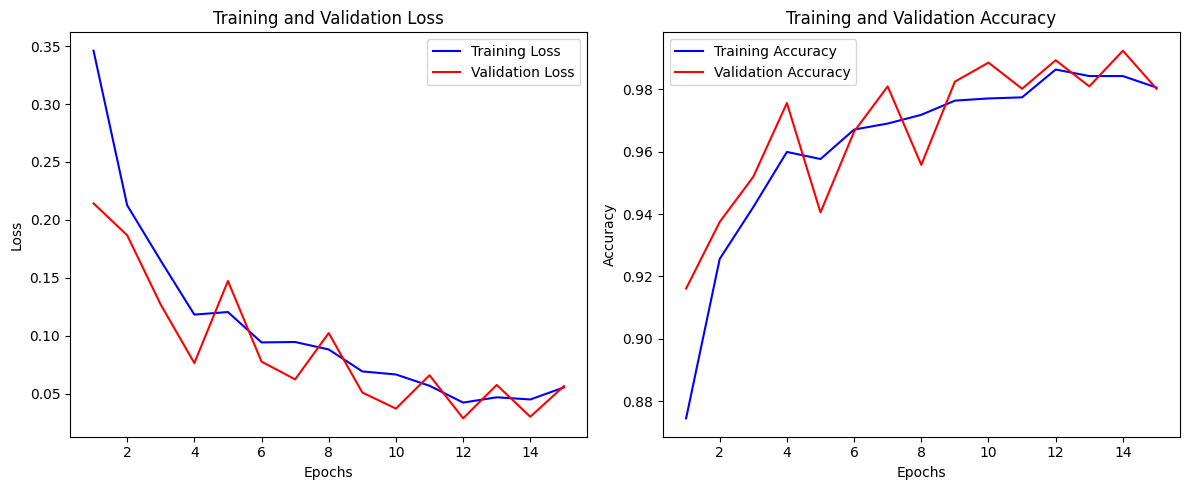

/tmp/ipykernel_40798/3361784703.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_tumor_classifier.pth'))


Test Accuracy: 0.9924

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



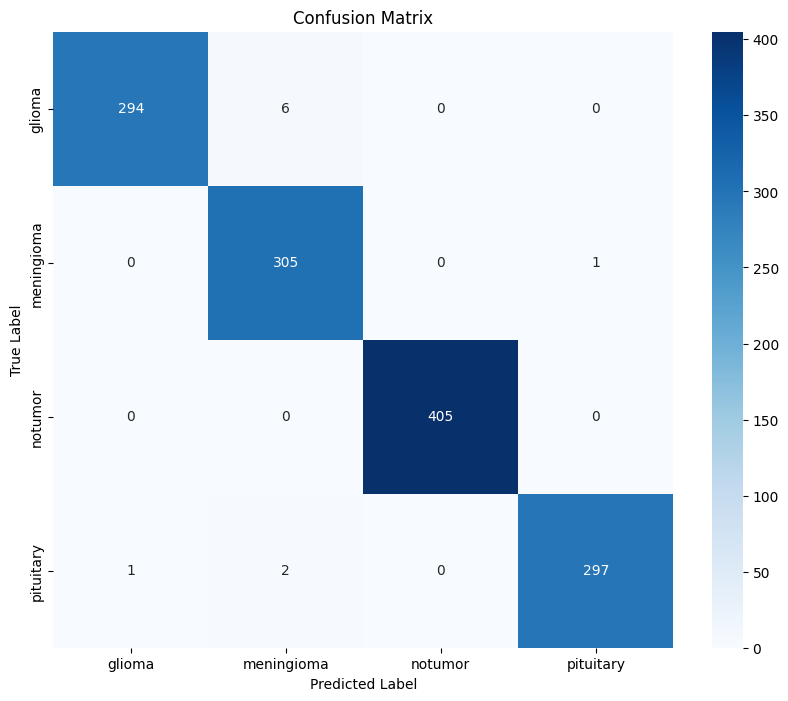


===== Detailed Performance Metrics =====
Overall Accuracy: 0.9924

Per-Class Metrics:
     Class  Precision  Recall  F1-Score
    glioma     0.9966  0.9800    0.9882
meningioma     0.9744  0.9967    0.9855
   notumor     1.0000  1.0000    1.0000
 pituitary     0.9966  0.9900    0.9933


Markdown Table for README:
| Class | Precision | Recall | F1-Score |
|-------|-----------|--------|----------|
| glioma | 0.9966 | 0.9800 | 0.9882 |
| meningioma | 0.9744 | 0.9967 | 0.9855 |
| notumor | 1.0000 | 1.0000 | 1.0000 |
| pituitary | 0.9966 | 0.9900 | 0.9933 |

**Overall Test Accuracy**: 99.24%
Final Test Accuracy: 0.9924
Model saved to 'tumor_classifier_model.pth'

===== Experiment Summary =====
Model: ResNet-50 (Transfer Learning)
Classes: glioma, meningioma, notumor, pituitary
Training dataset size: 5712
Testing dataset size: 1311
Best validation accuracy: 0.9924
Final test accuracy: 0.9924
Detailed metrics saved to: class_metrics.csv
Training history plot saved to: training_history.png
Co

In [9]:
# Train the model
if __name__ == "__main__":
    model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=15)
    
    # Plot training history
    plot_training_history(history)
    
    # Load best model for evaluation
    model.load_state_dict(torch.load('best_tumor_classifier.pth'))
    
    # Evaluate the model
    accuracy, predictions, true_labels = evaluate_model(model, test_loader)
    
    # Calculate and display detailed metrics
    metrics = calculate_detailed_metrics(true_labels, predictions, classes)
    
    print(f"Final Test Accuracy: {accuracy:.4f}")
    
    # Save the model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'classes': classes,
        'metrics': {  # Store metrics in the saved model for future reference
            'accuracy': accuracy,
            'precision': metrics['precision'].tolist(),
            'recall': metrics['recall'].tolist(),
            'f1': metrics['f1'].tolist()
        }
    }, 'tumor_classifier_model.pth')
    
    print("Model saved to 'tumor_classifier_model.pth'")
    
    # Generate a summary of the entire experiment
    print("\n===== Experiment Summary =====")
    print(f"Model: ResNet-50 (Transfer Learning)")
    print(f"Classes: {', '.join(classes)}")
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Testing dataset size: {len(test_dataset)}")
    print(f"Best validation accuracy: {max(history['val_acc']):.4f}")
    print(f"Final test accuracy: {accuracy:.4f}")
    print(f"Detailed metrics saved to: class_metrics.csv")
    print(f"Training history plot saved to: training_history.png")
    print(f"Confusion matrix saved to: confusion_matrix.png")
    print(f"Model checkpoint saved to: tumor_classifier_model.pth")